<a href="https://colab.research.google.com/github/AlMarNeuro/AlMarNR/blob/media108/Stajirovka_Media108_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Настройка хранилища, библиотек и глобальных переменных

- Инициализация

In [ ]:
# Подключение google-диска
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- Загрузка библиотек

In [ ]:
#
# Загрузка библиотек
#
import os # Работа с файловой системой

import time # Работа с системным временем

import pickle as pkl # Сериализация данных

import pandas as pd # Датафреймы
# Параметры отображения датафреймов
pd.options.display.max_rows     = 99
pd.options.display.max_colwidth = 999

import numpy as np

import regex as re

import librosa # Для параметризации аудио
import librosa.display # Для отображения аудио сигналов

import matplotlib.pyplot as plt # Для отрисовки графиков
plt.style.use('dark_background')

from google.colab import files # Для загрузки файлов
#import IPython.display as ipd # Для проигрывания аудио
#from IPython.display import Audio
#import seaborn as sns

###
# Подготовка данных
#import sklearn # Для нормирования
#from sklearn.preprocessing import LabelEncoder, StandardScaler # Масштабирование, нормировка данных
#from sklearn.model_selection import train_test_split # Разбиение на обучающую и проверочную выборку

from sklearn.utils import shuffle # Синхронно перемешать 2 набора данных (XTrain и YTrain)

# Функции-утилиты для работы с категориальными данными
# from keras.api._v2.keras import utils
# from keras.api._v2.keras.utils import to_categorical

# Рисование схемы модели
from keras.api._v2.keras.utils import plot_model

# Класс для конструирования последовательной модели нейронной сети
from keras.api._v2.keras.models import Sequential, Model
from keras.api._v2.keras.models import load_model


# Основные слои
from keras.api._v2.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input, concatenate
from keras.api._v2.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, Conv2D, MaxPooling1D, GlobalMaxPooling1D

# Оптимизаторы
from keras.api._v2.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop

# Токенизатор для преобразования текстов в последовательности
#from keras.api._v2.keras.preprocessing.text import Tokenizer

%matplotlib inline

- Переменные глобальные

In [ ]:
#
# Глобальные переменные
#
VM_CNT = '/content'
VM_CNT_DRV = VM_CNT + '/drive'
MY_CNT = '/content/drive/MyDrive/УИИ(marphida)/Стажировка_Media108'

WAV_PATH = VM_CNT_DRV + '/MyDrive/УИИ(marphida)/Стажировка_Media108/Audio/'
WAV_FILE = '2023-07-16_19-33-07.854622_from_79254254955_to_0111642_session_3091299879_talk.wav'
WAV_DATA = WAV_PATH + WAV_FILE

WAV_PRIMA = MY_CNT + '/Audio/Записи звонков_primavera/'
WAV_PAVEL = MY_CNT + '/Audio/Записи звонков_павелецкая сити'
WAV_HEADL = MY_CNT + '/Audio/Записи звонков_хедлайнер'
WAV_ZV_INFO = MY_CNT + '/Audio/Информация о звонках'

DF_HL = MY_CNT + '/РГ/Headliner_df.pkl'
DF_PAVEL_ST = MY_CNT + '/РГ/Paveletskaya_city_df.pkl'
DF_PAVEL_HL = MY_CNT + '/РГ/Paveletskaya_df.pkl'
DF_PRIMA = MY_CNT + '/РГ/Primavera_df.pkl'
DF_TOTAL = MY_CNT + '/РГ/total_df.pkl'
DF_TOTAL_MATCH = MY_CNT + '/РГ/total_match_df.pkl'
DF_TOTAL_NOT_MATCH = MY_CNT + '/РГ/total_not_match_df.pkl'

CSV_HL = MY_CNT + '/РП/Headliner_with_audio.csv'
CSV_PST = MY_CNT + '/РП/Павелецкая_ЖК_«Павелецкая_сити»_with_audio.csv'
CSV_PTB = MY_CNT + '/РП/Paveleckaya_with_audio.csv'
CSV_PRM = MY_CNT + '/РП/Primavera_with_audio.csv'

DUMP = '/content/drive/MyDrive/УИИ(marphida)/Стажировка_Media108/DataDump'

# Параметры предобработки аудиосигнала и подготовки обучающих выборок
#
SR = 8000 # Sample Rate - Частота дискетизации исходного звукового материала (звонки клиентов)
#
LEN_MEAN_AU = 10       # Шаг усреднения аудио
LEN_CONV1D_AU = 1000  # Размер окна одномерной свёртки аудио
STEP_CONV1D_AU = 100  # Шаг сдвига по свёртке аудио
#
# Параметры one-hot-encoding обработки
#
AU_OHE_CLASSES = 100
#

- Класс для измерение времени исполнения модулей

In [ ]:
# Контекстный менеджер для измерения времени операций
# Операция обертывается менеджером с помощью оператора with
class timex:
    def __enter__(self):
        # Фиксация времени старта процесса
        self.t = time.time()
        return self

    def __exit__(self, type, value, traceback):
        # Вывод времени работы
        print('Время обработки: {:.2f} с'.format(time.time() - self.t))

# Загрузка датафреймов с данными и функции обработки

- Загрузка датафреймов Романа с тегами и ссылками на аудиозвонки

In [ ]:
def load_datasets():
  # Headliner
  df_hl = pd.read_csv(CSV_HL)
  print(f'Headliner shape = {df_hl.shape}')
  # Paveletskaya_city
  df_pst = pd.read_csv(CSV_PST)
  print(f'Paveletskaya_city shape = {df_pst.shape}')
  # Paveletskaya_turbo
  df_ptb = pd.read_csv(CSV_PTB)
  print(f'Paveletskaya_turbo shape = {df_ptb.shape}')
  # Primavera
  df_pri = pd.read_csv(CSV_PRM)
  print(f'Primavera shape = {df_pri.shape}')
  return df_hl, df_pst, df_ptb, df_pri

- Загрузка сохранённых данных

In [ ]:
# Загрузка сохранённых даных первой свёртки
x_tr = np.load(DUMP+'/x_tr_1.npy')
y_tr = np.load(DUMP+'/y_tr_1.npy')
with open(DUMP+'/c_tr_1.pkl', 'rb') as pickle_in:
  c_tr = pkl.load(pickle_in)

In [ ]:
# Загрузка сохранённых даных ohe для предобработаного аудио
x_tr = np.load(DUMP+'/x_tr_ohe_1_29.npy')
y_tr = np.load(DUMP+'/y_tr_ohe_1_29.npy')
with open(DUMP+'/c_tr_ohe_1_29.pkl', 'rb') as pickle_in:
  c_tr = pkl.load(pickle_in)

- Функция фильтрации усреднением и свёртки (только для тестирования, в построении модели пока не применяется)
  - Усреднение и заданным шагом
  - Свёртка одномерным окном с заданным шагом


In [ ]:
# x_tr, y_tr = np.array([],[]).astype('float64'), np.array([], dtype='int') # Списки данных обучения
x_tr = np.empty((0, LEN_CONV1D_AU), dtype=np.float64) # Массив обучающей выборки
y_tr =  np.array([], dtype='int') # Массив выборки маркеров
c_tr = 0 # Переменная сохранения числа обработанных файлов
# x_tr= x_tr.astype('float64')
# df_mean = pd.Series(dtype='int')
for au_nm in df_hl_pre_tr.AudioFile:
  au_mean = np.array([], dtype='float64') # Массив сжатого аудиосигнала
  # загрузка аудио
  y, sr = librosa.load(WAV_PAVEL_HL+'/'+au_nm, sr=None)
  au_len = len(y)
  # Значение маркера текущего аудиофайла
  training_marker = df_hl_pre_tr.iloc[df_hl_pre_tr[df_hl_pre_tr.AudioFile == au_nm].index[0]]['Tags']
  print(f'\n<<<<< Файл: {au_nm} >>>>>')
  print(f'      Частота дискретизации: {sr}; длина записи: {au_len}; Маркер выборки: {training_marker}')
  # print(f'Значения амплитуды: {y[0:30]}...')

  # print(f'      Усредняем аудио с шагом {LEN_MEAN_AU}')
  mean_beg, mean_end = 0, LEN_MEAN_AU # Стартовый интервал усреднения
  while(mean_end <= au_len):
    au_mean = np.append(au_mean, y[mean_beg:mean_end].mean())
    mean_beg = mean_end
    mean_end += LEN_MEAN_AU
  au_mean_len = len(au_mean)
  print(f'      После сжатия усреднением с шагом {LEN_MEAN_AU} длина записи:{au_mean_len}')

  print(f'      Делаем обучающую выборку свёрткой окном {LEN_CONV1D_AU} с шагом {STEP_CONV1D_AU}')
  conv_beg, conv_end = 0, LEN_CONV1D_AU # Стартовый интервал интервала свёртки
  while(conv_end <= au_mean_len):
    # x_tr = np.append(x_tr, np.asarray(df_mean[conv_beg:conv_end]))
    x_tr = np.vstack((x_tr, np.asarray(au_mean[conv_beg:conv_end])))
    y_tr = np.append(y_tr, training_marker)
    conv_beg += STEP_CONV1D_AU
    conv_end += STEP_CONV1D_AU
  print(f'Размерность обучающей выборки: {x_tr.shape}')
  print(f'Размерность массива маркеров: {y_tr.shape}')
  c_tr += 1
  print(f'Обработано {c_tr} файлов из {df_hl_pre_tr.shape[0]}')
  print(f'Сохраняем промежуточный результат на диск... ')
  np.save(DUMP+'/x_tr_.npy', x_tr)
  np.save(DUMP+'/y_tr_.npy', y_tr)
  with open(DUMP+'/c_tr_.pkl', 'wb') as pickle_out:
    pkl.dump(c_tr, pickle_out)
#  break
del mean_beg, mean_end, au_mean, au_len, au_mean_len, conv_beg, conv_end, training_marker

- Функция, возвращающая ohe-hot-encoding индекс в заданном интервале

In [ ]:
# Функция, возвращающая ohe-hot-encoding индекс числа из заданного интервала, разбиваемого на указанное количество классов
#
# d_min, d_max - начало и конец интервала
# digit - число из указаннного выше интервала
# ohe_count - число ohe-классов, на которое необходимо разбивать интервал [d_min, d_max]
#
def get_ohe_in_interval(d_min, d_max, digit, ohe_count):
  d_min = float(d_min)
  d_max = float(d_max)
  digit = float(digit)
  ohe_count = int(ohe_count)

  if d_min >= d_max or digit < d_min or digit > d_max or ohe_count <= 1:
    print('Error in "get_ohe_in_interval(...)"')
    print(f'd_min >= d_max == {d_min >= d_max}')
    print(f'digit < d_min == {digit < d_min}')
    print(f'digit > d_max == {digit > d_max}')
    print(f'ohe_count <= 1 == {ohe_count <= 1}')
    return None

  # Формирование вектора с разбиеием интервала [d_min, d_max] с шагом ohe_count
  arr_ = np.linspace(d_min, d_max, ohe_count)

  # Возвращение индекса элемента для массива one-hot-encoding
  return np.flatnonzero(arr_ <= digit).max()

- Функция формирования OHE для предобработанного аудиосигнала

In [ ]:
#
# Функция, возвращающая one-hot-encoding предварительно сжатого аудио сигнала
#
# Входные данные:
# path_au - путь к папке с аудиофайлами на диске
# dfa - датафрейм с 2-мя столбцами:
#   - Tags - целевой(1)/нецелевой(0)
#   - AudioFile - имя аудиофайла
# LEN_MEAN_AU - шаг усреднения аудио (задан глобально)
# AU_OHE_CLASSES - размерность ohe-кодиовки каждого аудиосигнала (задан глобально)
#
# Возврат:
# x_tr_ - numpy ohe-массив размера: суммарное количество аудиозаписей/LEN_MEAN_AU Х AU_OHE_CLASSES
# y_tr_ - numpy массив 0/1 маркеров размера: суммарное количество аудиозаписей/LEN_MEAN_AU
# c_tr_contimue - номер аудиофайла(по порядку следования), с которого начинать(продолжать) обработку. 0 - сначала
# batch - количество файлов на обработку. 0 - обрабатывать все файлы
#
def get_audio_ohe(path_au, dfa, c_tr_contimue=0, batch=0):
  start_time = time.time()
  x_tr_ = np.empty((0, AU_OHE_CLASSES)) # Возвращаемый массив обучающей выборки
  y_tr_ =  np.empty((0,)) # Возвращаемый массив выборки маркеров
  c_tr_ = 0 # Переменная сохранения числа обработанных файлов
  batch_ = batch

  for au_nm_ in dfa.AudioFile:
    # >>>>> Вставка продолжение с c_tr_contimue файла <<<<<
    if c_tr_ < c_tr_contimue:
      c_tr_ += 1
      # print(c_tr_)
      continue
    # >>>>> Конец -> Вставка продолжение с c_tr_contimue файла <<<<<

    # Загрузка аудио
    y, sr = librosa.load(WAV_PAVEL_HL+'/'+au_nm_, sr=None)
    au_len_ = len(y)

    # Значение маркера текущего аудиофайла
    training_marker_ = dfa.iloc[dfa[dfa.AudioFile == au_nm_].index[0]]['Tags']

    print(f'\n<<<<< Файл: {au_nm_} >>>>>')
    print(f'      Частота дискретизации: {sr}; длина записи: {au_len_}; Маркер выборки: {training_marker_}')
    # print(f'Значения амплитуды: {y[0:30]}...')

    # Усредняем аудио с шагом LEN_MEAN_AU
    au_mean_ =  np.array([]) # Массив сжатого аудиосигнала
    au_mean_.resize(round(au_len_/LEN_MEAN_AU), refcheck=False)
    mean_beg_, mean_end_ = 0, LEN_MEAN_AU # Стартовый интервал адресов усреднения
    row_ = 0
    while(mean_end_ < au_len_):
      au_mean_[row_] = y[mean_beg_:mean_end_].mean()
      mean_beg_ = mean_end_
      mean_end_ += LEN_MEAN_AU
      row_ += 1
    au_mean_len_ = len(au_mean_)
    print(f'      После сжатия усреднением с шагом {LEN_MEAN_AU} длина записи:{au_mean_len_}')

    # Размах значений аудиосигнала
    au_min_ = au_mean_.min()
    au_max_ = au_mean_.max()
    print(f'      Минимальное значение сигнала: {au_min_}; Максимальное значение сигнала:{au_max_}')
    print(f'      Делаем обучающую выборку one-hot-encoding размером {AU_OHE_CLASSES}. Интервал ohe: {(au_max_-au_min_)/AU_OHE_CLASSES}')

    row_ = x_tr_.shape[0]
    x_tr_.resize(x_tr_.shape[0] + au_mean_len_, AU_OHE_CLASSES, refcheck=False)
    y_tr_.resize(y_tr_.shape[0] + au_mean_len_, refcheck=False)
    for au_data in au_mean_:
      x_tr_[row_, get_ohe_in_interval(au_min_, au_max_, au_data, AU_OHE_CLASSES)] = 1
      y_tr_[row_] = training_marker_
      row_ += 1

    print(f'Размерность обучающей выборки: {x_tr_.shape}')
    print(f'Размерность массива маркеров: {y_tr_.shape}')

    c_tr_ += 1
    print(f'Обработано {c_tr_} файлов из {dfa.shape[0]}')
    print(f'Время обработки файла: {round((time.time()-start_time)/60, 2)} минут')

    if batch_ != 0:
      batch_ -= 1
      if batch_ == 0:
        break
      else:
        continue

  fx = '/x_tr_ohe_.npy'
  fy = '/y_tr_ohe_.npy'
  fc = '/c_tr_ohe_.pkl'

  if c_tr_contimue != 0:
    fx = '/x_tr_ohe_'+ str(c_tr_contimue)+'.npy'
    fy = '/y_tr_ohe_'+ str(c_tr_contimue)+'.npy'
    fc = '/c_tr_ohe_'+ str(c_tr_contimue)+'.pkl'

  print(f'Сохраняем результаты на диск... ')
  np.save(DUMP + fx, x_tr_)
  np.save(DUMP + fy, y_tr_)
  with open(DUMP + fc, 'wb') as pickle_out:
    pkl.dump(c_tr_, pickle_out)

  return x_tr_, y_tr_, c_tr_

# Свёрточная модель на необработанном аудио

## Предобработка датасетов обучения

- **Функция формирования предвыборок обучения**

In [ ]:
##### Функция формирования датафрейма соответствия аудиофайлов и соответствующих им признаков целевой/нецелевой
#####
##### get_tags_vs_audio (path_csv)
#####
##### Входные параметры:
##### path_csv - адрес датафрейма csv содержащим столбец целевых тегов
#####
##### Возвращаемые данные:
##### df_tags_audio_ - датафрейм со столбцами:
#####      'Tags' - wелевой/нецелевой(1/0)
#####      'Audio' -  соответствующе тегам имена аудиофайлов

def get_tags_vs_audio (path_csv, name_who):
  df_csv_ = pd.read_csv(path_csv)
  df_csv_ = df_csv_.fillna('')
  print(f'Размерность исходного csv-файла: {df_csv_.shape}')
  # Копирование наименований аудиофайлов всех целевых тегов
  df_tags_audio_ = df_csv_[df_csv_['Теги'].str.contains('Целевой')][['Теги', 'Аудиофайл']].copy()
  if name_who=='Headliner':
    df_tags_audio_ = pd.concat( [df_tags_audio_, df_csv_[df_csv_['Теги'].str.contains('целевой')][['Теги', 'Аудиофайл']].copy()] )

##  df_tags_audio_ = df_csv_[df_csv_['Теги'].str.contains(r'Целевой|целевой', case=False, regex=True)][['Теги', 'Аудиофайл']].copy()
##  df_tags_audio_ = pd.concat( [df_tags_audio_, df_csv_[df_csv_['Теги'].str.contains('Целевой')][['Теги', 'Аудиофайл']].copy()] )
  # Копирование наименований аудиофайлов всех нецелевых тегов
  df_tags_audio_ = pd.concat( [df_tags_audio_, df_csv_[df_csv_['Теги'].str.contains('Нецелевой')][['Теги', 'Аудиофайл']].copy()] )
  if name_who=='Headliner':
    df_tags_audio_ = pd.concat( [df_tags_audio_, df_csv_[df_csv_['Теги'].str.contains('нецелевой')][['Теги', 'Аудиофайл']].copy()] )

##  df_tags_audio_ = pd.concat( [df_tags_audio_, df_csv_[df_csv_['Теги'].str.contains(r'Нецелевой|нецелевой', case=False, regex=True)][['Теги', 'Аудиофайл']].copy()] )
  # Переименование имён столбцов
  df_tags_audio_.rename(columns = {'Теги':'Tags', 'Аудиофайл':'AudioFile'}, inplace=True )
  print(f'Отфильтровано для обучения записей: {df_tags_audio_.shape}')
  # Избавление от ошибки фильтрации по NaN
  df_tags_audio_ = df_tags_audio_.fillna('')
  # Все нецелевые = 0
  #df_tags_audio_ = df_tags_audio_.astype({'Tags': str}) # Избавление от ошибки нестроковых данных
  df_tags_audio_.loc[df_tags_audio_.Tags.str.contains('Нецелевой', na=False), 'Tags'] = 0
  if name_who=='Headliner':
    df_tags_audio_.loc[df_tags_audio_.Tags.str.contains('нецелевой', na=False), 'Tags'] = 0

##  df_tags_audio_.loc[df_tags_audio_.Tags.str.contains(r'Нецелевой|нецелевой', case=False, regex=True, na=False), 'Tags'] = 0
  #df_tags_audio_.loc[df_tags_audio_.Tags.str.contains(r'\bНецелевой', case=False, regex=True, na=False), 'Tags'] = 0
  #df_tags_audio_.loc[df_tags_audio_.Tags.str.contains('нецелевой', na=False), 'Tags'] = 0
  # Все целевые = 1
###  df_tags_audio_ = df_tags_audio_.astype({'Tags': str}) # Избавление от ошибки нестроковых данных
  df_tags_audio_.loc[df_tags_audio_.Tags.str.contains('Целевой', na=False), 'Tags'] = 1
  if name_who=='Headliner':
    df_tags_audio_.loc[df_tags_audio_.Tags.str.contains('целевой', na=False), 'Tags'] = 1

##  df_tags_audio_.loc[df_tags_audio_.Tags.str.contains(r'Целевой|целевой', case=False, regex=True, na=False), 'Tags'] = 1
  #df_tags_audio_.loc[df_tags_audio_.Tags.str.contains(r'\bЦелевой', case=False, regex=True, na=False), 'Tags'] = 1
  #df_tags_audio_.loc[df_tags_audio_.Tags.str.contains('целевой', na=False), 'Tags'] = 1
  # Изменение типа столбца 'Tags'
  df_tags_audio_ = df_tags_audio_.astype({'Tags': int})
  # Удаление записей без аудиофайлов
  df_tags_audio_ = df_tags_audio_[df_tags_audio_.AudioFile != '']
  # Сброс старых индексов
  df_tags_audio_.reset_index(drop=True, inplace=True)
  print(f"Баланс целевые/нецелевые:\n\
          Целевые: {len(df_tags_audio_[df_tags_audio_.Tags==1])}\n\
          Нецелевые: {len(df_tags_audio_[df_tags_audio_.Tags==0])}")
  return df_tags_audio_

- **Функция получения датафреймов с необработанными аудио + тегами**

In [ ]:
#####
##### Получение всех тегов с полными путями к аудио
#####
def get_pre_train():
  name_list_ = ['Headliner','Paveletskaya_city', 'Paveletskaya_turbo', 'Primavera']
  csv_list_ = [CSV_HL, CSV_PST, CSV_PTB, CSV_PRM]
  audio_list_ = [WAV_HEADL, WAV_PAVEL, WAV_PAVEL, WAV_PRIMA]
  proj_len_ = len(name_list_)
  df_tags_audio_full_ = pd.DataFrame()
  for i in range(proj_len_):
    # df_csv_ = pd.read_csv(csv_list_[i])
    print(f'\n         Обработка {name_list_[i]}...\n')
    # print(f'{name_list_[i]} shape = {df_csv_.shape}')
    df_tags_audio_ = get_tags_vs_audio(csv_list_[i], name_list_[i])
###    df_tags_audio_['AudioFile'] = str(audio_list_[i])+"/"+df_tags_audio_['AudioFile']
    df_tags_audio_['DataNumber'] = i
    df_tags_audio_full_ = pd.concat([df_tags_audio_full_, df_tags_audio_], ignore_index = True)
  # Переиндексация
  df_tags_audio_full_.reset_index(drop=True, inplace=True)
  return df_tags_audio_full_

## ► Модуль создания датафрейма - исходника для формирование выборок обученеия

In [ ]:
#
# df_pre_train - датафрейм-исходник для генерации обучающих выборок
#
with timex():

  df_pre_train = get_pre_train()

  print('=======================')
  print(f'\nРазмерность сводных данных: {df_pre_train.shape}')
  print(f"Сводный баланс целевые/нецелевые:\n\
          Целевые: {len(df_pre_train[df_pre_train.Tags==1])}\n\
          Нецелевые: {len(df_pre_train[df_pre_train.Tags==0])}")



         Обработка Headliner...

Размерность исходного csv-файла: (2045, 73)
Отфильтровано для обучения записей: (1097, 2)
Баланс целевые/нецелевые:
          Целевые: 859
          Нецелевые: 238

         Обработка Paveletskaya_city...

Размерность исходного csv-файла: (1000, 76)
Отфильтровано для обучения записей: (527, 2)
Баланс целевые/нецелевые:
          Целевые: 290
          Нецелевые: 237

         Обработка Paveletskaya_turbo...

Размерность исходного csv-файла: (1784, 76)
Отфильтровано для обучения записей: (1290, 2)
Баланс целевые/нецелевые:
          Целевые: 290
          Нецелевые: 1000

         Обработка Primavera...

Размерность исходного csv-файла: (1517, 75)
Отфильтровано для обучения записей: (1310, 2)
Баланс целевые/нецелевые:
          Целевые: 648
          Нецелевые: 662

Размерность сводных данных: (4224, 3)
Сводный баланс целевые/нецелевые:
          Целевые: 2087
          Нецелевые: 2137
Время обработки: 5.59 с


In [ ]:
#
# Равномерное перемешивание Целевых и Нецелевых в датафрейме для формирование датасетов обучения
#

dft_0 = df_pre_train[df_pre_train.Tags==0]
dft_1 = df_pre_train[df_pre_train.Tags==1]

df_p_t_new = pd.DataFrame(columns = df_pre_train.columns)

flag_0_1 = True
i0, i1 = 0, 0

for ii in range(min(len(dft_0), len(dft_1)) * 2):
  if flag_0_1 == True:
    df_p_t_new.loc[len(df_p_t_new.index)] = dft_0.iloc[i0]
#    df_p_t_new = pd.concat( [df_p_t_new, dft_0.iloc[i0]], axis = 0, ignore_index = True)
    i0 += 1
    flag_0_1 = False
  else:
    df_p_t_new.loc[len(df_p_t_new.index)] = dft_1.iloc[i1]
#    df_p_t_new = pd.concat( [df_p_t_new, dft_1.iloc[i1]], axis = 0, ignore_index = True)
    i1 += 1
    flag_0_1 = True

df_pre_train = df_p_t_new.copy()

del dft_0, dft_1, df_p_t_new, ii, flag_0_1, i0, i1


In [ ]:
df_pre_train

,Tags,AudioFile,DataNumber
0,0,2023-07-19_15-35-00.597395_from_74951397391_to_0188880_session_3097826533_talk.mp3,0
1,1,2023-05-22_10-16-39.852630_from_79175582996_to_74957898990_session_2955352133_talk.mp3,0
2,0,2023-07-19_14-06-31.860077_from_79916000360_to_74957898990_session_3104061795_talk.mp3,0
3,1,2023-07-19_17-12-58.258412_from_79991345109_to_74959339902_session_3099072526_talk.mp3,0
4,0,2023-07-19_11-40-46.765315_from_79636236173_to_0188880_session_3097851001_talk.mp3,0
...,...,...,...
4169,1,2023-05-02_14-23-41.246677_from_79099221244_to_0197872_session_2917197011_talk.mp3,3
4170,0,2023-05-12_08-43-24.365428_from_73452427822_to_0197879_session_2945566020_talk.mp3,3
4171,1,2023-05-02_11-45-20.432052_from_79037581605_to_0111652_session_2916596803_talk.mp3,3
4172,0,2023-05-12_08-42-59.625280_from_73452427822_to_0197879_session_2945563440_talk.mp3,3


## ► Схема построения свёрточной НС
- Первый слой - свертка, с ядром CONV_SIZE_1 и смещением на каждом шаге свертки CONV_STRIDE_1
- Далее набор из нескольких одинаковых блоков классифицирующих сверточных сетей -  свертка (с ядром  CONV_SIZE) + пулинг (длина пуллинга PULL_SIZE)
- Финальные слои - Conv1D, Flattern и бинарный классификатор на слое Dense.

## Функция создания модели

In [ ]:
#Создаем модель
def create_model(
      sections, # Список с количеством фильтров в классифицирующих секциях
      filter_length,  # Размер ядра свёрточных фильтров
      pooling_length, # Размер пулингов
      outActivation   # Активация на последнем слое
    ):

    #Вход
    input_raw = Input(shape=(X_train1.shape[1], X_train1.shape[2]))

    #Входной сверточный слой
    x = Conv1D(128, filter_length, padding="same", strides=strider, activation="relu")(input_raw)
    x = BatchNormalization()(x)

    #Классифицирующие секции - свертка + пулинг
    for s in sections:
        x = Conv1D(s, filter_length, padding="same", activation="relu")(x)
        x = MaxPooling1D(pool_size = pooling_length)(x)
        x = BatchNormalization()(x)

    #Последняя свертка + подготовка к Dense
    x = Conv1D(512, 1, padding="same", activation="relu")(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)

    #Dense
    x = Dense(2, activation = outActivation)(x)

    #Возвращаем модель
    return Model([input_raw], x)

## ► Функция создания и компиляции модели

In [ ]:
def create_compile_model():

  model_au_ = create_model(SECTIONS, CONV_SIZE, PULL_SIZE, 'softmax') # 'sigmoid'

  # Компиляция модели
  model_au_.compile(
      optimizer=Adam(learning_rate=1e-2),
      loss='categorical_crossentropy',
  #    loss='binary_crossentropy',
      metrics=['accuracy'])

  # Вывод сводки
  model_au_.summary()

  # Вывод схемы модели
  display(plot_model(model_au_, dpi=60, show_shapes=True))

  return model_au_

- Компиляция модели

In [ ]:
model_au = load_model(DUMP + '/model_au.h5')

model_au.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
#    loss='binary_crossentropy',
    metrics=['accuracy'])


## Функция обучения модели

In [ ]:
# Garbage Collector - use it like gc.collect()
# Callback очистки памяти после каждой эпохи
import tensorflow as tf
import gc

class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()


In [ ]:
def trainModel(model, X_train1, Y_train1, X_train1V, Y_train1V, batch_size, epochs):

  history = model.fit(X_train1,
                      Y_train1,
                      epochs=epochs,
                      batch_size=batch_size,
                      validation_data=(X_train1V, Y_train1V),
                      verbose = 1)#,
                      #callbacks=[GarbageCollectorCallback()],)

  # Вывод графиков точности и ошибки
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
  fig.suptitle('График процесса обучения модели')
  ax1.plot(history.history['accuracy'],
              label='Доля верных ответов на обучающем наборе')
  ax1.plot(history.history['val_accuracy'],
              label='Доля верных ответов на проверочном наборе')
  ax1.xaxis.get_major_locator().set_params(integer=True)
  ax1.set_xlabel('Эпоха обучения')
  ax1.set_ylabel('Доля верных ответов')
  ax1.legend()

  ax2.plot(history.history['loss'],
              label='Ошибка на обучающем наборе')
  ax2.plot(history.history['val_loss'],
              label='Ошибка на проверочном наборе')
  ax2.xaxis.get_major_locator().set_params(integer=True)
  ax2.set_xlabel('Эпоха обучения')
  ax2.set_ylabel('Ошибка')
  ax2.legend()
  plt.show()

## **Параметры обучения**

In [ ]:
#
# Параметры свёрточной модели
#
CONV_SIZE_1 = 3 # Ядро свёртки на 1-м шаге
CONV_STRIDE_1 = 7 # Смещение ядра свёртки на 1-м шаге
CONV_SIZE = 3 # Ядро свёртки на 2-м и последующих свёрточных слоях (размер фильтра свёртки)
CONV_STRIDE = 3 # Смещение ядра свёртки на 2-м и последующих свёрточных слоях
PULL_SIZE = 3 # Размер пуллинга на 2-м и последующих свёрточных слоях

CUTTING_PART_TRAIN = 2 # На какую часть нарезки сдвигать ядро свёртки на обучении
CUTTING_PART_PREDICT = 7  # На какую часть нарезки сдвигать ядро свёртки на тестировании

# PART_TO_TRAIN = 10 # ~ 1 / PART_TO_TRAIN на валидацию и тестирование, остальое - на обучение

# Количество фильтров (параметр filters в Conv1D ) в сверточных слоях
# в каждом из классифицирующих блоков
SECTIONS = [128, 128, 256, 256, 256, 256, 256, 512, 512]

# Блоки аудиофайлов для циклоа обучения
#    [0, 200],
#    [200, 400],
#    [400, 600],
#    [600, 800],
#    [800, 1000],
#    [1000, 1200],
#    [1200, 1300],
#    [1300, 1400],
#    [1400, 1500],
#    [1500, 1600],


TR_BLOCKS = [
    [1600, 1700],
    [1700, 1800],
    [1800, 1900],
    [1900, 2000],
    [2000, 2100],
    [2100, 2200],
    [2200, 2300],
    [2300, 2400],
    [2400, 2500],
    [2500, 2600],
    [2600, 2700],
    [2700, 2800],
    [2800, 2900],
    [2900, 3000],
    [3000, 3100],
    [3100, 3200],
    [3200, 3300],
    [3300, 3400],
    [3400, 3500],
    [3500, 3600],
    [3600, 3700],
    [3700, 3800],
    [3800, 3900],
    [3900, 4000],
    [4000, 4174]
]



## ► Модуль запуска циклического обучения
  - формирование блоков датасетов обучения, приемлемых для конфигурации ВМ Colaboratory, на подмножествах аудиофайлов
  - сохранение датасетов тестирования
  - циклический запуск обучения с сохранением/востановлением модели обучения


Запущен блок [0_200] - 1-й из 21
[0-200]=> Headliner: № 1 -> Длина записи: 627311; Маркер выборки: 0; Число нарезок: 4
[0-200]=> Headliner: № 2 -> Длина записи: 1038575; Маркер выборки: 1; Число нарезок: 7
[0-200]=> Headliner: № 3 -> Длина записи: 85871; Маркер выборки: 0; Число нарезок: 0
[0-200]=> Headliner: № 4 -> Длина записи: 3149039; Маркер выборки: 1; Число нарезок: 22
[0-200]=> Headliner: № 5 -> Длина записи: 507503; Маркер выборки: 0; Число нарезок: 3
[0-200]=> Headliner: № 6 -> Длина записи: 3586223; Маркер выборки: 1; Число нарезок: 26
[0-200]=> Headliner: № 7 -> Длина записи: 331247; Маркер выборки: 0; Число нарезок: 2
[0-200]=> Headliner: № 8 -> Длина записи: 423407; Маркер выборки: 1; Число нарезок: 3
[0-200]=> Headliner: № 9 -> Длина записи: 530543; Маркер выборки: 0; Число нарезок: 3
[0-200]=> Headliner: № 10 -> Длина записи: 3575279; Маркер выборки: 1; Число нарезок: 25
[0-200]=> Headliner: № 11 -> Длина записи: 297839; Маркер выборки: 0; Число нарезок: 2
[0-200]=> He

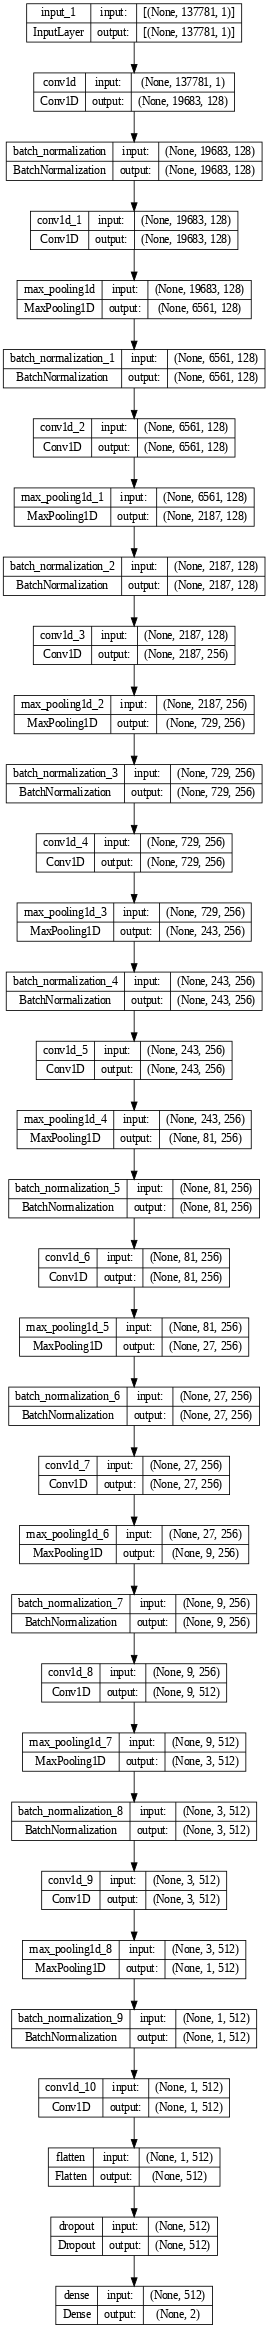


XTrain1.shape:  (3210, 137781, 1)
YTrain1.shape:  (3210, 2)
XTrain1V.shape:  (287, 137781, 1)
YTrain1V.shape:  (287, 2)
Обучающая выборка X_Train1 - Целевых: 2734; Нецелевых: 476
Валидационная выборка X_Train1V - Целевых: 268; Нецелевых: 19
Epoch 1/20
26/26 [==============================] - 55s 1s/step - loss: 1.4228 - accuracy: 0.7601 - val_loss: 26.8218 - val_accuracy: 0.9338
Epoch 2/20
26/26 [==============================] - 28s 1s/step - loss: 0.7043 - accuracy: 0.8178 - val_loss: 0.2656 - val_accuracy: 0.9338
Epoch 3/20
26/26 [==============================] - 29s 1s/step - loss: 0.5859 - accuracy: 0.8221 - val_loss: 0.4318 - val_accuracy: 0.9338
Epoch 4/20
26/26 [==============================] - 29s 1s/step - loss: 0.4385 - accuracy: 0.8402 - val_loss: 3.2148 - val_accuracy: 0.9338
Epoch 5/20
26/26 [==============================] - 29s 1s/step - loss: 0.4343 - accuracy: 0.8449 - val_loss: 0.4714 - val_accuracy: 0.9338
Epoch 6/20
26/26 [==============================] - 29s 1

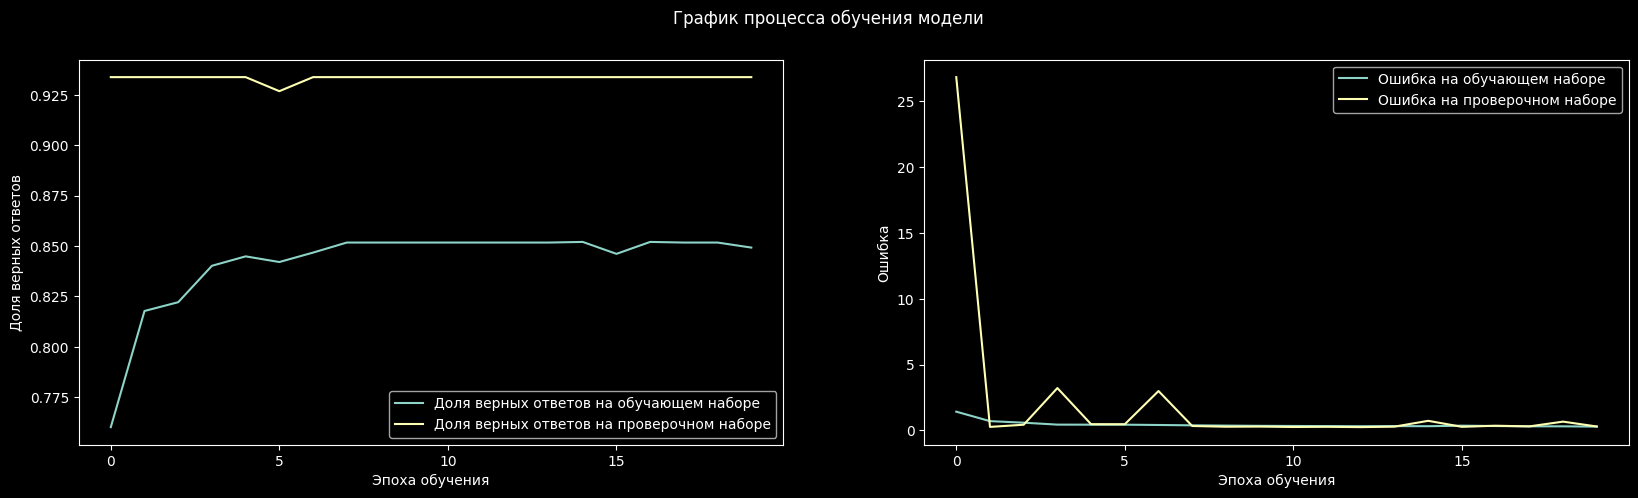

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Завершён блок [0_200] - 1-й из 21 

Запущен блок [200_400] - 2-й из 21
[200-400]=> Headliner: № 201 -> Длина записи: 240815; Маркер выборки: 0; Число нарезок: 1
[200-400]=> Headliner: № 202 -> Длина записи: 2676143; Маркер выборки: 1; Число нарезок: 19
[200-400]=> Headliner: № 203 -> Длина записи: 245999; Маркер выборки: 0; Число нарезок: 1
[200-400]=> Headliner: № 204 -> Длина записи: 2593775; Маркер выборки: 1; Число нарезок: 18
[200-400]=> Headliner: № 205 -> Длина записи: 192431; Маркер выборки: 0; Число нарезок: 1
[200-400]=> Headliner: № 206 -> Длина записи: 6835439; Маркер выборки: 1; Число нарезок: 49
[200-400]=> Headliner: № 207 -> Длина записи: 512687; Маркер выборки: 0; Число нарезок: 3
[200-400]=> Headliner: № 208 -> Длина записи: 2294831; Маркер выборки: 1; Число нарезок: 16
[200-400]=> Headliner: № 209 -> Длина записи: 88751; Маркер выборки: 0; Число нарезок: 0
[200-400]=> Headliner: № 210 -> Длина записи: 779375; Маркер выборки: 1; Число нарезок: 5
[200-400]=> Headliner:

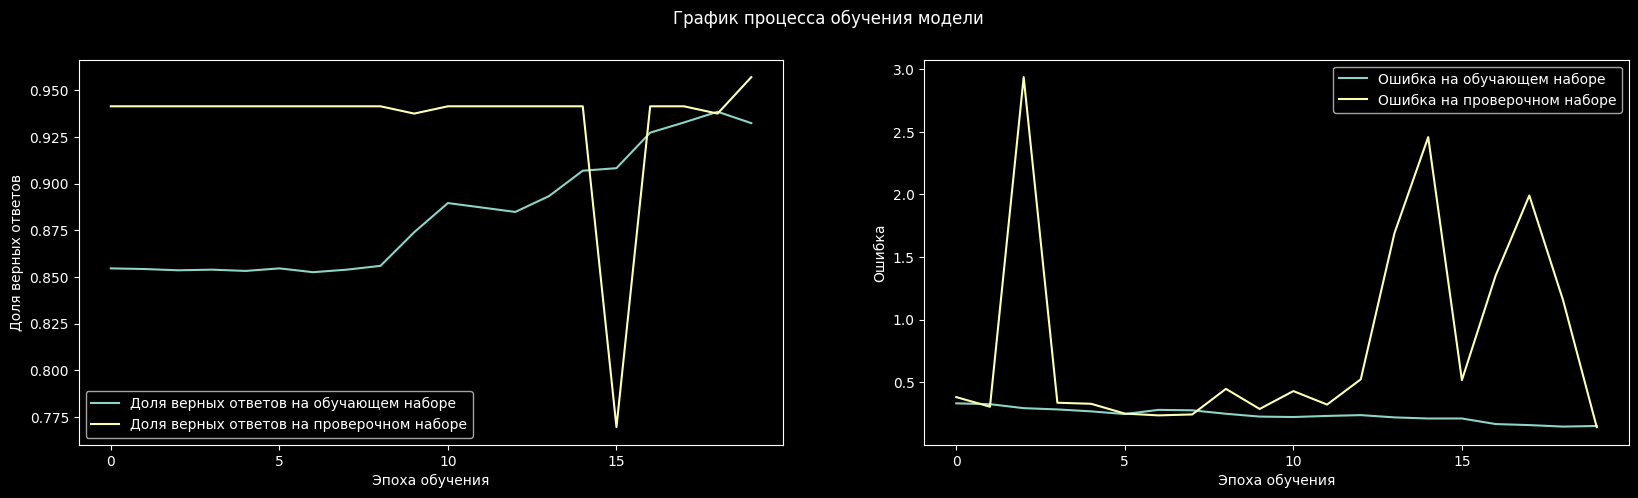

Завершён блок [200_400] - 2-й из 21 

Запущен блок [400_600] - 3-й из 21
[400-600]=> Headliner: № 401 -> Длина записи: 329519; Маркер выборки: 0; Число нарезок: 2
[400-600]=> Headliner: № 402 -> Длина записи: 2908271; Маркер выборки: 1; Число нарезок: 21
[400-600]=> Headliner: № 403 -> Длина записи: 352559; Маркер выборки: 0; Число нарезок: 2
[400-600]=> Headliner: № 404 -> Длина записи: 2947439; Маркер выборки: 1; Число нарезок: 21
[400-600]=> Headliner: № 405 -> Длина записи: 325487; Маркер выборки: 0; Число нарезок: 2
[400-600]=> Headliner: № 406 -> Длина записи: 2173871; Маркер выборки: 1; Число нарезок: 15
[400-600]=> Headliner: № 407 -> Длина записи: 153839; Маркер выборки: 0; Число нарезок: 1
[400-600]=> Headliner: № 408 -> Длина записи: 790319; Маркер выборки: 1; Число нарезок: 5
[400-600]=> Headliner: № 409 -> Длина записи: 620399; Маркер выборки: 0; Число нарезок: 4
[400-600]=> Headliner: № 410 -> Длина записи: 2314415; Маркер выборки: 1; Число нарезок: 16
[400-600]=> Headlin

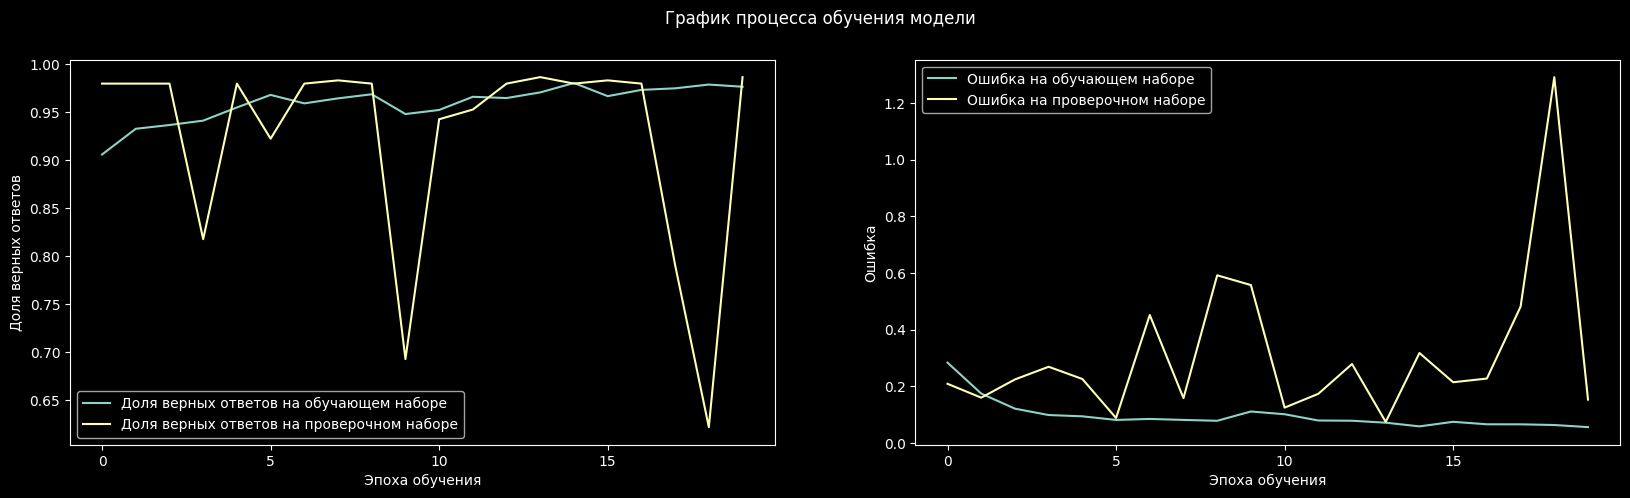

Завершён блок [400_600] - 3-й из 21 

Запущен блок [600_800] - 4-й из 21
[600-800]=> Paveletskaya_city: № 601 -> Длина записи: 15599; Маркер выборки: 0; Число нарезок: 0
[600-800]=> Headliner: № 602 -> Длина записи: 1931951; Маркер выборки: 1; Число нарезок: 14
[600-800]=> Paveletskaya_city: № 603 -> Длина записи: 133679; Маркер выборки: 0; Число нарезок: 0
[600-800]=> Headliner: № 604 -> Длина записи: 1586927; Маркер выборки: 1; Число нарезок: 11
[600-800]=> Paveletskaya_city: № 605 -> Длина записи: 29423; Маркер выборки: 0; Число нарезок: 0
[600-800]=> Headliner: № 606 -> Длина записи: 425711; Маркер выборки: 1; Число нарезок: 3
[600-800]=> Paveletskaya_city: № 607 -> Длина записи: 129071; Маркер выборки: 0; Число нарезок: 0
[600-800]=> Headliner: № 608 -> Длина записи: 4136303; Маркер выборки: 1; Число нарезок: 30
[600-800]=> Paveletskaya_city: № 609 -> Длина записи: 3454895; Маркер выборки: 0; Число нарезок: 25
[600-800]=> Headliner: № 610 -> Длина записи: 5197871; Маркер выборки: 

In [ ]:
with timex():
  neuro_au()



---




Запущен блок [600_800] - 1-й из 18
[600-800]=> Paveletskaya_city: № 1 -> Длина записи: 15599; Маркер выборки: 0; Число нарезок: 0
[600-800]=> Headliner: № 2 -> Длина записи: 1931951; Маркер выборки: 1; Число нарезок: 14
[600-800]=> Paveletskaya_city: № 3 -> Длина записи: 133679; Маркер выборки: 0; Число нарезок: 0
[600-800]=> Headliner: № 4 -> Длина записи: 1586927; Маркер выборки: 1; Число нарезок: 11
[600-800]=> Paveletskaya_city: № 5 -> Длина записи: 29423; Маркер выборки: 0; Число нарезок: 0
[600-800]=> Headliner: № 6 -> Длина записи: 425711; Маркер выборки: 1; Число нарезок: 3
[600-800]=> Paveletskaya_city: № 7 -> Длина записи: 129071; Маркер выборки: 0; Число нарезок: 0
[600-800]=> Headliner: № 8 -> Длина записи: 4136303; Маркер выборки: 1; Число нарезок: 30
[600-800]=> Paveletskaya_city: № 9 -> Длина записи: 3454895; Маркер выборки: 0; Число нарезок: 25
[600-800]=> Headliner: № 10 -> Длина записи: 5197871; Маркер выборки: 1; Число нарезок: 37
[600-800]=> Paveletskaya_city: № 11

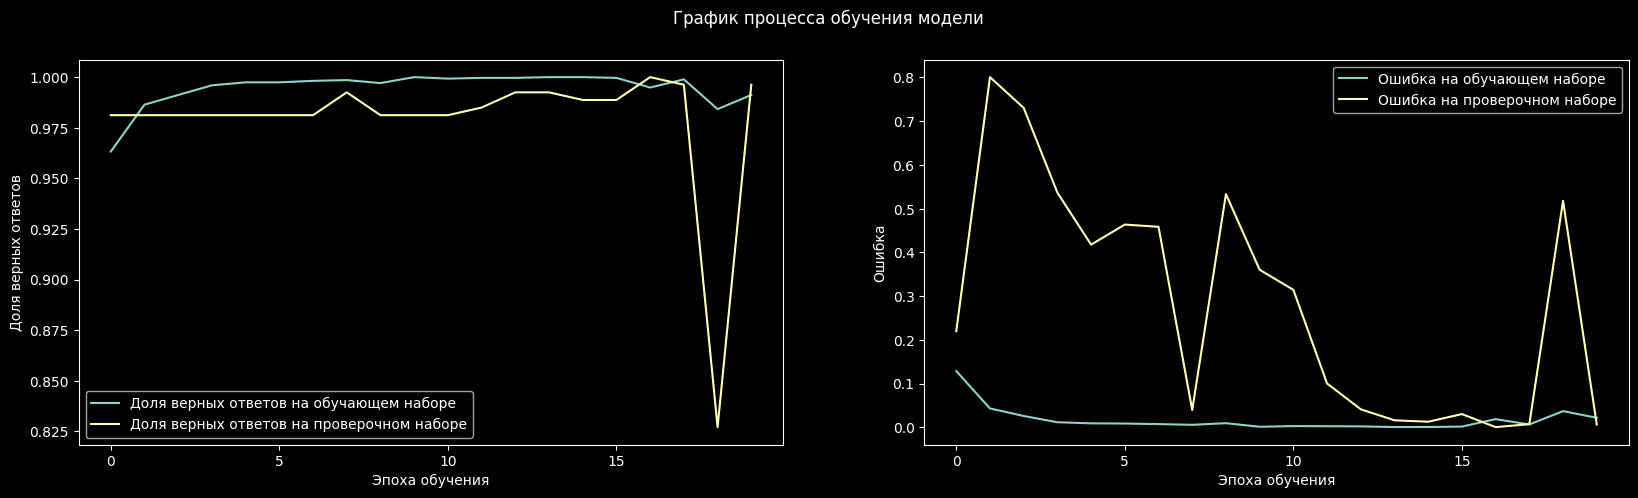

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Завершён блок [600_800] - 1-й из 18 

Запущен блок [800_1000] - 2-й из 18
[800-1000]=> Paveletskaya_city: № 201 -> Длина записи: 117551; Маркер выборки: 0; Число нарезок: 0
[800-1000]=> Headliner: № 202 -> Длина записи: 650351; Маркер выборки: 1; Число нарезок: 4
[800-1000]=> Paveletskaya_city: № 203 -> Длина записи: 104879; Маркер выборки: 0; Число нарезок: 0
[800-1000]=> Headliner: № 204 -> Длина записи: 5269871; Маркер выборки: 1; Число нарезок: 38
[800-1000]=> Paveletskaya_city: № 205 -> Длина записи: 16751; Маркер выборки: 0; Число нарезок: 0
[800-1000]=> Headliner: № 206 -> Длина записи: 3154223; Маркер выборки: 1; Число нарезок: 22
[800-1000]=> Paveletskaya_city: № 207 -> Длина записи: 56495; Маркер выборки: 0; Число нарезок: 0
[800-1000]=> Headliner: № 208 -> Длина записи: 3468719; Маркер выборки: 1; Число нарезок: 25
[800-1000]=> Paveletskaya_city: № 209 -> Длина записи: 31727; Маркер выборки: 0; Число нарезок: 0
[800-1000]=> Headliner: № 210 -> Длина записи: 4040111; Маркер в

ResourceExhaustedError: ignored

In [ ]:
with timex():
  neuro_au()


Запущен блок [800_1000] - 1-й из 17
[800-1000]=> Paveletskaya_city: № 1 -> Длина записи: 117551; Маркер выборки: 0; Число нарезок: 0
[800-1000]=> Headliner: № 2 -> Длина записи: 650351; Маркер выборки: 1; Число нарезок: 4
[800-1000]=> Paveletskaya_city: № 3 -> Длина записи: 104879; Маркер выборки: 0; Число нарезок: 0
[800-1000]=> Headliner: № 4 -> Длина записи: 5269871; Маркер выборки: 1; Число нарезок: 38
[800-1000]=> Paveletskaya_city: № 5 -> Длина записи: 16751; Маркер выборки: 0; Число нарезок: 0
[800-1000]=> Headliner: № 6 -> Длина записи: 3154223; Маркер выборки: 1; Число нарезок: 22
[800-1000]=> Paveletskaya_city: № 7 -> Длина записи: 56495; Маркер выборки: 0; Число нарезок: 0
[800-1000]=> Headliner: № 8 -> Длина записи: 3468719; Маркер выборки: 1; Число нарезок: 25
[800-1000]=> Paveletskaya_city: № 9 -> Длина записи: 31727; Маркер выборки: 0; Число нарезок: 0
[800-1000]=> Headliner: № 10 -> Длина записи: 4040111; Маркер выборки: 1; Число нарезок: 29
[800-1000]=> Paveletskaya_c

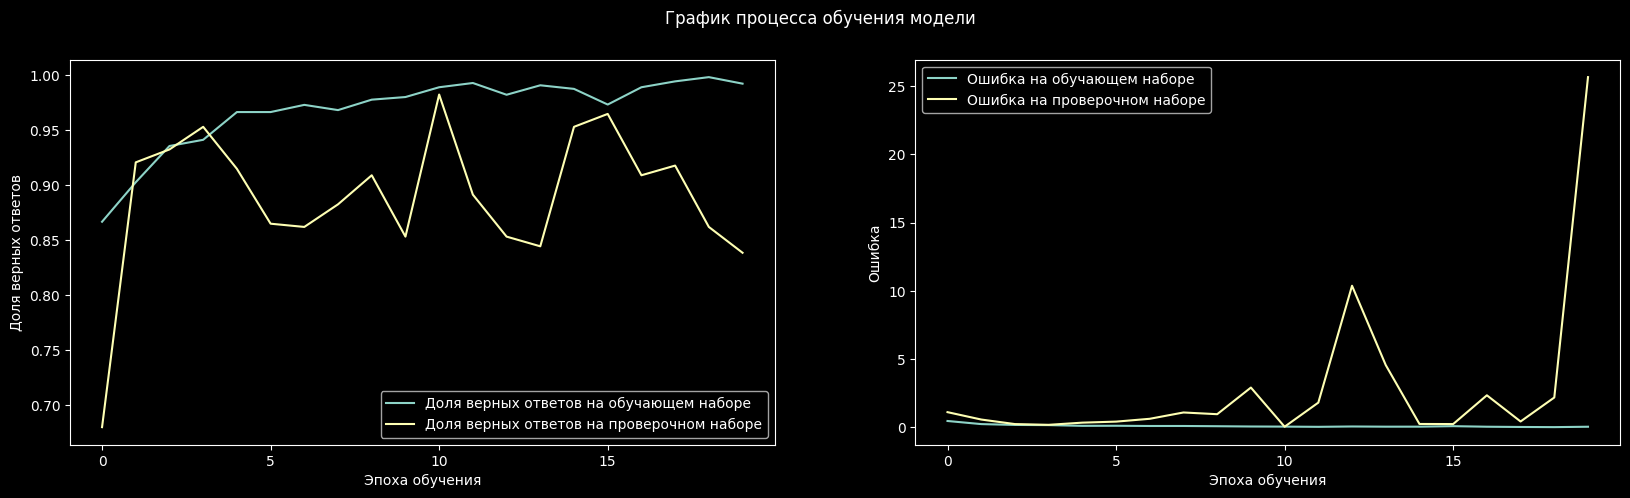

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Завершён блок [800_1000] - 1-й из 17 

Запущен блок [1000_1200] - 2-й из 17
[1000-1200]=> Paveletskaya_turbo: № 201 -> Длина записи: 3661103; Маркер выборки: 0; Число нарезок: 26
[1000-1200]=> Headliner: № 202 -> Длина записи: 3242927; Маркер выборки: 1; Число нарезок: 23
[1000-1200]=> Paveletskaya_turbo: № 203 -> Длина записи: 61103; Маркер выборки: 0; Число нарезок: 0
[1000-1200]=> Headliner: № 204 -> Длина записи: 2897903; Маркер выборки: 1; Число нарезок: 21
[1000-1200]=> Paveletskaya_turbo: № 205 -> Длина записи: 72623; Маркер выборки: 0; Число нарезок: 0
[1000-1200]=> Headliner: № 206 -> Длина записи: 1195823; Маркер выборки: 1; Число нарезок: 8
[1000-1200]=> Paveletskaya_turbo: № 207 -> Длина записи: 1287407; Маркер выборки: 0; Число нарезок: 9
[1000-1200]=> Headliner: № 208 -> Длина записи: 3456623; Маркер выборки: 1; Число нарезок: 25
[1000-1200]=> Paveletskaya_turbo: № 209 -> Длина записи: 1082351; Маркер выборки: 0; Число нарезок: 7
[1000-1200]=> Headliner: № 210 -> Длина за

In [ ]:
with timex():
  neuro_au()


Запущен блок [1000_1200] - 1-й из 16
[1000-1200]=> Paveletskaya_turbo: № 1 -> Длина записи: 3661103; Маркер выборки: 0; Число нарезок: 26
[1000-1200]=> Headliner: № 2 -> Длина записи: 3242927; Маркер выборки: 1; Число нарезок: 23
[1000-1200]=> Paveletskaya_turbo: № 3 -> Длина записи: 61103; Маркер выборки: 0; Число нарезок: 0
[1000-1200]=> Headliner: № 4 -> Длина записи: 2897903; Маркер выборки: 1; Число нарезок: 21
[1000-1200]=> Paveletskaya_turbo: № 5 -> Длина записи: 72623; Маркер выборки: 0; Число нарезок: 0
[1000-1200]=> Headliner: № 6 -> Длина записи: 1195823; Маркер выборки: 1; Число нарезок: 8
[1000-1200]=> Paveletskaya_turbo: № 7 -> Длина записи: 1287407; Маркер выборки: 0; Число нарезок: 9
[1000-1200]=> Headliner: № 8 -> Длина записи: 3456623; Маркер выборки: 1; Число нарезок: 25
[1000-1200]=> Paveletskaya_turbo: № 9 -> Длина записи: 1082351; Маркер выборки: 0; Число нарезок: 7
[1000-1200]=> Headliner: № 10 -> Длина записи: 1592111; Маркер выборки: 1; Число нарезок: 11
[1000

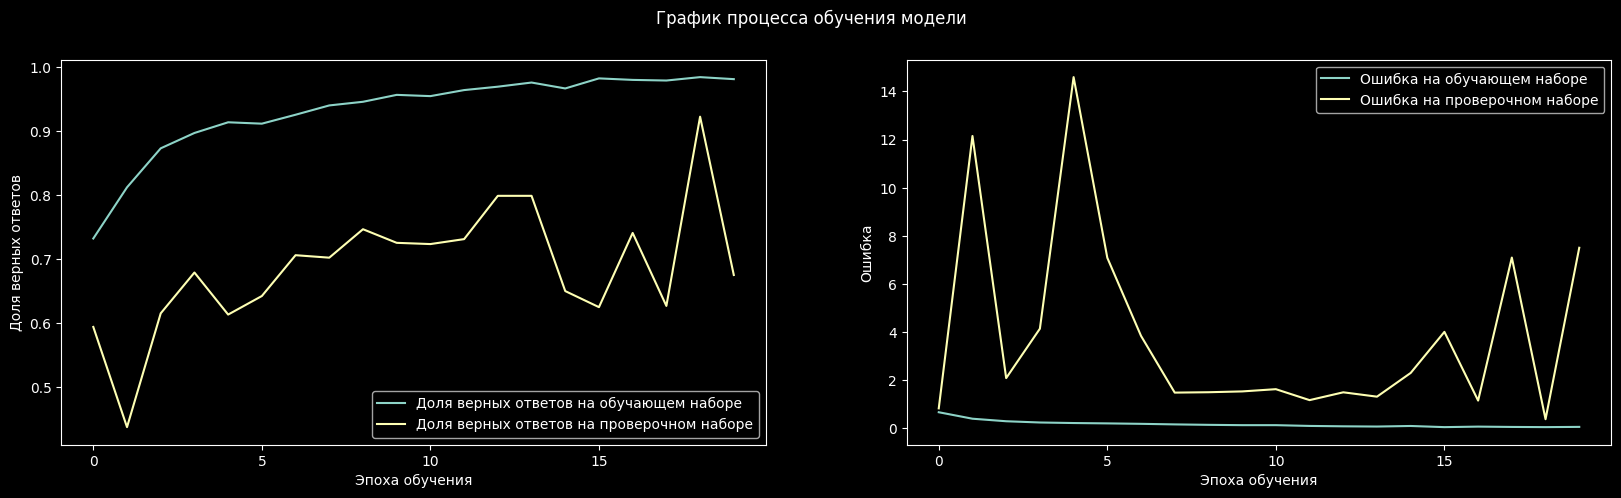

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Завершён блок [1000_1200] - 1-й из 16 

Запущен блок [1200_1400] - 2-й из 16
[1200-1400]=> Paveletskaya_turbo: № 201 -> Длина записи: 1832303; Маркер выборки: 0; Число нарезок: 13
[1200-1400]=> Headliner: № 202 -> Длина записи: 742511; Маркер выборки: 1; Число нарезок: 5
[1200-1400]=> Paveletskaya_turbo: № 203 -> Длина записи: 2633519; Маркер выборки: 0; Число нарезок: 19
[1200-1400]=> Headliner: № 204 -> Длина записи: 1798319; Маркер выборки: 1; Число нарезок: 13
[1200-1400]=> Paveletskaya_turbo: № 205 -> Длина записи: 14447; Маркер выборки: 0; Число нарезок: 0
[1200-1400]=> Headliner: № 206 -> Длина записи: 1963631; Маркер выборки: 1; Число нарезок: 14
[1200-1400]=> Paveletskaya_turbo: № 207 -> Длина записи: 1849583; Маркер выборки: 0; Число нарезок: 13
[1200-1400]=> Headliner: № 208 -> Длина записи: 1688303; Маркер выборки: 1; Число нарезок: 12
[1200-1400]=> Paveletskaya_turbo: № 209 -> Длина записи: 2403695; Маркер выборки: 0; Число нарезок: 17
[1200-1400]=> Headliner: № 210 -> Дли

In [ ]:
with timex():
  neuro_au()

In [ ]:
with timex():
  neuro_au()


Запущен блок [1600_1700] - 1-й из 25
[1600-1700]=> Paveletskaya_turbo: № 1 -> Длина записи: 328367; Маркер выборки: 0; Число нарезок: 2
[1600-1700]=> Headliner: № 2 -> Длина записи: 292079; Маркер выборки: 1; Число нарезок: 2
[1600-1700]=> Paveletskaya_turbo: № 3 -> Длина записи: 2690543; Маркер выборки: 0; Число нарезок: 19
[1600-1700]=> Headliner: № 4 -> Длина записи: 1254575; Маркер выборки: 1; Число нарезок: 9
[1600-1700]=> Paveletskaya_turbo: № 5 -> Длина записи: 417071; Маркер выборки: 0; Число нарезок: 3
[1600-1700]=> Headliner: № 6 -> Длина записи: 1347887; Маркер выборки: 1; Число нарезок: 9
[1600-1700]=> Paveletskaya_turbo: № 7 -> Длина записи: 2191151; Маркер выборки: 0; Число нарезок: 15
[1600-1700]=> Headliner: № 8 -> Длина записи: 1012079; Маркер выборки: 1; Число нарезок: 7
[1600-1700]=> Paveletskaya_turbo: № 9 -> Длина записи: 876719; Маркер выборки: 0; Число нарезок: 6
[1600-1700]=> Headliner: № 10 -> Длина записи: 2203823; Маркер выборки: 1; Число нарезок: 15
[1600-1


Запущен блок [1600_1650] - 1-й из 51
[1600-1650]=> Paveletskaya_turbo: № 1 -> Длина записи: 328367; Маркер выборки: 0; Число нарезок: 2
[1600-1650]=> Headliner: № 2 -> Длина записи: 292079; Маркер выборки: 1; Число нарезок: 2
[1600-1650]=> Paveletskaya_turbo: № 3 -> Длина записи: 2690543; Маркер выборки: 0; Число нарезок: 19
[1600-1650]=> Headliner: № 4 -> Длина записи: 1254575; Маркер выборки: 1; Число нарезок: 9
[1600-1650]=> Paveletskaya_turbo: № 5 -> Длина записи: 417071; Маркер выборки: 0; Число нарезок: 3
[1600-1650]=> Headliner: № 6 -> Длина записи: 1347887; Маркер выборки: 1; Число нарезок: 9
[1600-1650]=> Paveletskaya_turbo: № 7 -> Длина записи: 2191151; Маркер выборки: 0; Число нарезок: 15
[1600-1650]=> Headliner: № 8 -> Длина записи: 1012079; Маркер выборки: 1; Число нарезок: 7
[1600-1650]=> Paveletskaya_turbo: № 9 -> Длина записи: 876719; Маркер выборки: 0; Число нарезок: 6
[1600-1650]=> Headliner: № 10 -> Длина записи: 2203823; Маркер выборки: 1; Число нарезок: 15
[1600-1

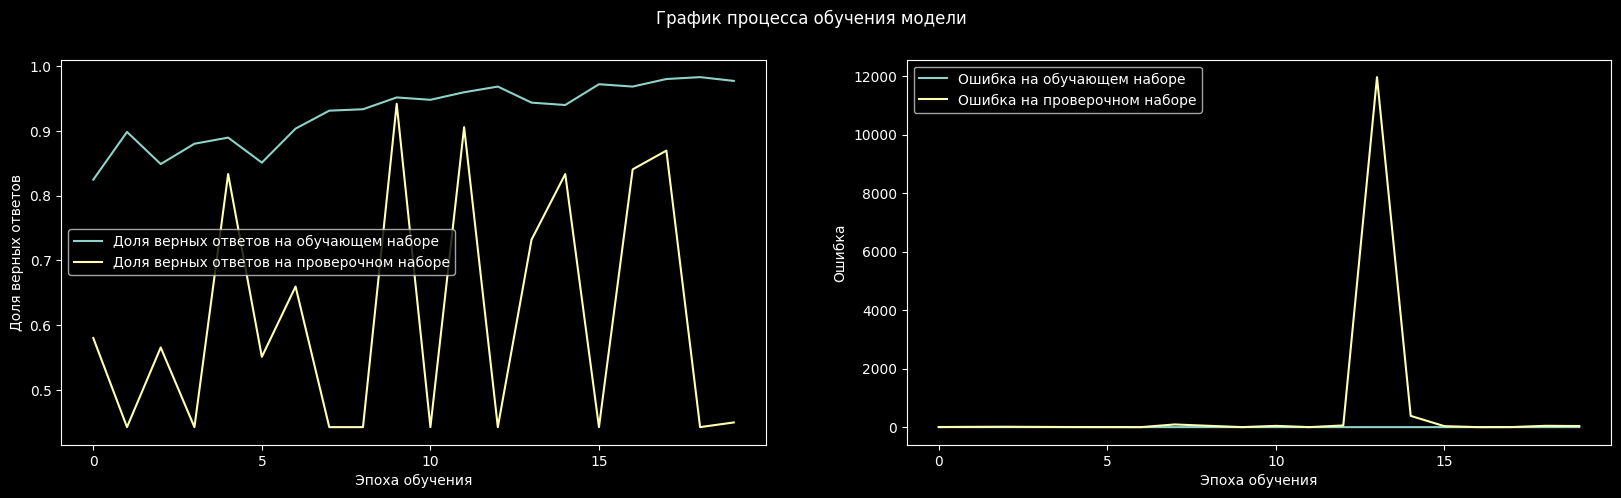

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Завершён блок [1600_1650] - 1-й из 51 

Запущен блок [1650_1700] - 2-й из 51
[1650-1700]=> Paveletskaya_turbo: № 51 -> Длина записи: 1457327; Маркер выборки: 0; Число нарезок: 10
[1650-1700]=> Headliner: № 52 -> Длина записи: 4548143; Маркер выборки: 1; Число нарезок: 33
[1650-1700]=> Paveletskaya_turbo: № 53 -> Длина записи: 275951; Маркер выборки: 0; Число нарезок: 2
[1650-1700]=> Headliner: № 54 -> Длина записи: 5041775; Маркер выборки: 1; Число нарезок: 36
[1650-1700]=> Paveletskaya_turbo: № 55 -> Длина записи: 5372399; Маркер выборки: 0; Число нарезок: 38
[1650-1700]=> Headliner: № 56 -> Длина записи: 855407; Маркер выборки: 1; Число нарезок: 6
[1650-1700]=> Paveletskaya_turbo: № 57 -> Длина записи: 77231; Маркер выборки: 0; Число нарезок: 0
[1650-1700]=> Headliner: № 58 -> Длина записи: 2176751; Маркер выборки: 1; Число нарезок: 15
[1650-1700]=> Paveletskaya_turbo: № 59 -> Длина записи: 3480815; Маркер выборки: 0; Число нарезок: 25
[1650-1700]=> Headliner: № 60 -> Длина записи: 1

In [ ]:
with timex():
  neuro_au()